<a href="https://colab.research.google.com/github/lanej5/mlb/blob/main/elo/features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

The primary output of this notebook is `features.parquet`. Each row corresponds to a game. 

## Feature overview

- Aggregated team statistics for home and visitor, e.g., win percentage, team pitching stats, and team batting stats.
- Percentage of rest days in last n days (for several different values of n)
- Travel distance between games.

All team specific features for a given game are labelled with `home_` or `visitor_` prefix.

Starting pitcher features will be added in another notebook.

## Data sources
- Retrosheet.org (historical baseball data)
- Nominatim.org (geographical data)

In [ ]:
import pandas as pd
pd.options.display.max_columns = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/mlb/retrosheet/'
! ls '/content/drive/My Drive/mlb/retrosheet/'

biofile.csv  GL1995.csv  GL2001.csv  GL2007.csv  GL2013.csv  GL2019.csv
GL1990.csv   GL1996.csv  GL2002.csv  GL2008.csv  GL2014.csv  GL2020.csv
GL1991.csv   GL1997.csv  GL2003.csv  GL2009.csv  GL2015.csv  GL2021.csv
GL1992.csv   GL1998.csv  GL2004.csv  GL2010.csv  GL2016.csv  LEAGUEABR.csv
GL1993.csv   GL1999.csv  GL2005.csv  GL2011.csv  GL2017.csv  parks.csv
GL1994.csv   GL2000.csv  GL2006.csv  GL2012.csv  GL2018.csv  TEAMABR.csv


# legend

In [ ]:
!wget https://www.retrosheet.org/gamelogs/glfields.txt

!cat glfields.txt

--2022-07-09 02:05:50--  https://www.retrosheet.org/gamelogs/glfields.txt
Resolving www.retrosheet.org (www.retrosheet.org)... 192.124.249.9
Connecting to www.retrosheet.org (www.retrosheet.org)|192.124.249.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6559 (6.4K) [text/plain]
Saving to: ‘glfields.txt’

glfields.txt        100%[===================>]   6.41K  --.-KB/s    in 0s      

2022-07-09 02:05:50 (263 MB/s) - ‘glfields.txt’ saved [6559/6559]

Field(s)  Meaning
    1     Date in the form "yyyymmdd"
    2     Number of game:
             "0" -- a single game
             "1" -- the first game of a double (or triple) header
                    including seperate admission doubleheaders
             "2" -- the second game of a double (or triple) header
                    including seperate admission doubleheaders
             "3" -- the third game of a triple-header
             "A" -- the first game of a double-header involving 3 teams
             "B"

# load, clean, concat game logs 1990 - 2021

In [ ]:
import pandas as pd
from typing import Dict

def get_team_index_map(file: str) -> Dict['str', int]:
    """Returns a dict mapping team abbr from 1990 - 2021 to a
    dense set of indices.

    If a team changed at some point between 1990 - 2021, the old
    team abbr is mapped to the same index as the new team abbr.

    Args:
    -----
    file: valid path to TEAMABR.csv from retrosheets.
    """
    teams = pd.read_csv(file)

    # filter out teams that ceased to exist before 2021
    current_teams = teams[teams['Last year of this combination'] == 2021] \
    .reset_index(drop=True)

    # create mapping
    team_index_map = dict(zip(current_teams['Team Abbreviation'], current_teams.index))

    # add changed team abbr
    team_index_map['MON'] = team_index_map['WAS']
    team_index_map['CAL'] = team_index_map['ANA']
    team_index_map['FLO'] = team_index_map['MIA']

    # save as a dataframe
    team_ids = pd.DataFrame(team_index_map.items(), columns=['abbr', 'id'])
    team_ids.to_csv('/content/drive/My Drive/mlb/features/team_ids.csv')

    return team_index_map

def clean(gl):
    """
    clean the dataframe:
        1. parse dates
        2. convert abbr to team ids 
        3. rename stat columns 
        4. add run differential and win columns
        5. drop tie games
        6. add integer date index 
        7. sort dates
        8. add game index
    """
    team_ids = get_team_index_map('/content/drive/My Drive/mlb/retrosheet/TEAMABR.csv')

    # dict for renaming stat columns
    cols = {
        '4': 'visitor_L',
        '7': 'home_L',
        '9': 'visitor_R',
        '10': 'home_R',
        '16': 'park_ID',
        '21': 'visitor_AB',
        '22': 'visitor_H',
        '23': 'visitor_2B',
        '24': 'visitor_3B',
        '25': 'visitor_HR',
        '28': 'visitor_SF',
        '29': 'visitor_HBP',
        '30': 'visitor_BB',
        '40': 'visitor_ER',
        '49': 'home_AB',
        '50': 'home_H',
        '51': 'home_2B',
        '52': 'home_3B',
        '53': 'home_HR',
        '56': 'home_SF',
        '57': 'home_HBP',
        '58': 'home_BB',
        '68': 'home_ER',
        '101': 'visitor_sp_id',
        '102': 'visitor_sp_name',
        '103': 'home_sp_id',
        '104': 'home_sp_name',
    }

    # parse dates
    gl = gl.assign(date=pd.to_datetime(gl['0'], format='%Y%m%d'))
    gl = gl.assign(season=gl['date'].dt.year)

    # replace abbr with team_id
    gl = gl.assign(visitor_id=gl['3'].map(team_ids)) \
    .assign(home_id=gl['6'].map(team_ids))

    # rename columns
    gl = gl.rename(columns=cols)

    # drop unnamed columns
    to_drop = list(set(gl.columns).intersection([str(i) for i in range(161)]))
    gl = gl.drop(columns=to_drop)
    
    # assign
    gl = gl.assign(home_1B=gl['home_H'] - gl['home_2B'] - gl['home_3B'] - gl['home_HR'])
    gl = gl.assign(visitor_1B=gl['visitor_H'] - gl['visitor_2B'] - gl['visitor_3B'] - gl['visitor_HR'])
    gl = gl.assign(RD=gl['home_R'] - gl['visitor_R'])
    gl = gl.assign(W=(gl['RD'] > 0).astype(int))
    gl = gl.assign(interleague=(gl['home_L'] != gl['visitor_L']).astype(int))

    # drop tie games
    gl = gl.drop(gl[gl['RD'] == 0].index)

    # add date and game indexes
    gl = gl.assign(date_index=gl['date'].rank(method='dense'))
    gl = gl.sort_values('date')
    gl = gl.reset_index(drop=True) \
    .reset_index(drop=False).rename(columns={'index': 'game_id'})

    return gl

def load_game_logs():
    gls = []

    for y in range(1990, 2022):
        filename = '/content/drive/My Drive/mlb/retrosheet/GL' + str(y) + '.csv'
        gls.append(pd.read_csv(filename))

    return pd.concat(gls).pipe(clean)

In [ ]:
# create game logs
gl = load_game_logs()
gl.head()

,game_id,visitor_L,home_L,visitor_R,home_R,park_ID,visitor_AB,visitor_H,visitor_2B,visitor_3B,visitor_HR,visitor_SF,visitor_HBP,visitor_BB,visitor_ER,home_AB,home_H,home_2B,home_3B,home_HR,home_SF,home_HBP,home_BB,home_ER,visitor_sp_id,visitor_sp_name,home_sp_id,home_sp_name,date,season,visitor_id,home_id,home_1B,visitor_1B,RD,W,interleague,date_index
0,0,AL,AL,2,5,BOS07,33,5,1,0,0,1,0,4,2,33,8,4,0,0,0,0,4,2,morrj001,Jack Morris,clemr001,Roger Clemens,1990-04-09,1990,5,2,4,4,3,1,0,1.0
1,1,AL,AL,7,4,ANA01,40,15,2,0,1,0,0,1,2,31,5,0,0,1,1,0,5,7,holmb001,Brian Holman,blylb001,Bert Blyleven,1990-04-09,1990,11,0,4,12,-3,0,0,1.0
2,2,AL,AL,1,2,CHI10,30,4,1,0,0,0,1,1,2,29,6,1,1,0,1,0,2,1,bosic001,Chris Bosio,perem001,Melido Perez,1990-04-09,1990,23,3,4,3,1,1,0,1.0
3,3,AL,AL,3,8,OAK01,37,10,1,0,1,0,0,2,7,32,11,2,0,2,1,0,6,3,andea001,Allan Anderson,stewd001,Dave Stewart,1990-04-09,1990,8,10,7,8,5,1,0,1.0
4,4,AL,AL,2,4,ARL01,28,3,2,0,0,0,0,5,4,30,7,1,1,2,0,1,6,2,stott001,Todd Stottlemyre,ryann001,Nolan Ryan,1990-04-09,1990,14,13,3,1,2,1,0,1.0


# ballparks and travel distance

Travel distance of visiting team as a feature.

In [ ]:
from datetime import datetime

!wget https://www.retrosheet.org/parkcode.txt

parkcode = pd.read_csv('parkcode.txt', parse_dates=['START', 'END'])

# select only parks used since 1990
parkcode = parkcode[(parkcode['END'] > datetime(1990, 1, 1)) ^ parkcode['END'].isna()]

# drop outliers (both teams need to travel to these remote locations so there's no travel advantage anyways)
parkcode = parkcode[~parkcode['PARKID'].isin(['HON01', 'LON01', 'TOK01', 'SYD01', 'SJU01', 'MNT01'])]

parkcode

--2022-07-08 21:00:53--  https://www.retrosheet.org/parkcode.txt
Resolving www.retrosheet.org (www.retrosheet.org)... 192.124.249.9
Connecting to www.retrosheet.org (www.retrosheet.org)|192.124.249.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20707 (20K) [text/plain]
Saving to: ‘parkcode.txt.19’

parkcode.txt.19     100%[===================>]  20.22K  --.-KB/s    in 0.02s   

2022-07-08 21:00:53 (1.18 MB/s) - ‘parkcode.txt.19’ saved [20707/20707]



,PARKID,NAME,AKA,CITY,STATE,START,END,LEAGUE,NOTES
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,1966-04-19,NaT,AL,NaN
3,ARL01,Arlington Stadium,NaN,Arlington,TX,1972-04-21,1993-10-03,AL,NaN
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,1994-04-11,2019-09-29,AL,NaN
5,ARL03,Globe Life Field in Arlington,NaN,Arlington,TX,2020-07-24,NaT,AL,NaN
6,ATL01,Atlanta-Fulton County Stadium,NaN,Atlanta,GA,1966-04-12,1996-09-23,NL,NaN
...,...,...,...,...,...,...,...,...,...
223,STP01,Tropicana Field,NaN,St. Petersburg,FL,1998-03-31,NaT,AL,NaN
235,TOR02,Rogers Centre,Skydome,Toronto,ONT,1989-06-05,NaT,AL,NaN
248,WAS10,Robert F. Kennedy Stadium,D.C. Stadium,Washington,DC,1962-04-09,2007-09-23,NaN,AL:1962-71; NL:2005-07
249,WAS11,Nationals Park,NaN,Washington,DC,2008-03-30,NaT,NL,NaN


In [ ]:
# some parks have the same location (city, state)
# let's use unique city, state pairs to get geolocation data 
# because this is rate limited and slow

locations = parkcode[['CITY', 'STATE']].drop_duplicates()
len(locations)

37

In [ ]:
! pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# get latitude and longitude of parks 
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="mlb_postseason_dash")

lat_long = []

for i, r in locations.iterrows():
    location_name = r['CITY'] + ", " + r['STATE']
    location = geolocator.geocode(location_name)
    lat_long.append((r['CITY'], r['STATE'], location.latitude, location.longitude))
    time.sleep(2) # avoid getting rate limited by openstreetmap

lat_long_df = pd.DataFrame(data=lat_long, columns=['CITY', 'STATE', 'lat', 'long'])

In [ ]:
lat_long_df

,CITY,STATE,lat,long
0,Anaheim,CA,33.834752,-117.911732
1,Arlington,TX,32.735582,-97.107119
2,Atlanta,GA,33.748992,-84.390264
3,Baltimore,MD,39.290882,-76.610759
4,Boston,MA,42.355433,-71.060511
5,Buffalo,NY,42.886717,-78.878392
6,Chicago,IL,41.875562,-87.624421
7,Cincinnati,OH,39.101454,-84.512460
8,Cleveland,OH,41.499656,-81.693681
9,Denver,CO,39.739236,-104.984862


In [ ]:
# get pairwise distances between cities

from geopy.distance import geodesic

distances = []

for i in range(len(lat_long_df)):
    c_i, s_i = lat_long_df.loc[i, 'CITY'], lat_long_df.loc[i, 'STATE']
    ll_i = (lat_long_df.loc[i, 'lat'], lat_long_df.loc[i, 'long'])
    for j in range(i+1, len(lat_long_df)):
        ll_j = (lat_long_df.loc[j, 'lat'], lat_long_df.loc[j, 'long'])
        d = geodesic(ll_i, ll_j).kilometers
        distances.append((c_i, s_i, lat_long_df.loc[j, 'CITY'], lat_long_df.loc[j, 'STATE'], d))
        time.sleep(1.1) # avoid getting rate limited by openstreetmap



In [ ]:
distances_df = pd.DataFrame(data=distances, columns=['CITY_1', 'STATE_1', 'CITY_2', 'STATE_2', 'geodesic distance (km)'])

In [ ]:
distances_df

,CITY_1,STATE_1,CITY_2,STATE_2,geodesic distance (km)
0,Anaheim,CA,Arlington,TX,1938.513119
1,Anaheim,CA,Atlanta,GA,3090.411121
2,Anaheim,CA,Baltimore,MD,3713.824667
3,Anaheim,CA,Boston,MA,4162.349483
4,Anaheim,CA,Buffalo,NY,3521.477167
...,...,...,...,...,...
661,St. Petersburg,FL,Washington,DC,1339.915504
662,St. Petersburg,FL,Williamsport,PA,1582.247817
663,Toronto,ONT,Washington,DC,564.312929
664,Toronto,ONT,Williamsport,PA,339.611785


In [ ]:
dist_df = pd.merge(
    parkcode[['PARKID', 'CITY', 'STATE']],
    distances_df,
    how='left',
    left_on=['CITY', 'STATE'],
    right_on=['CITY_1', 'STATE_1']
).drop(columns=['CITY', 'STATE', 'CITY_1', 'STATE_1']).dropna()

dist_df = pd.merge(
    parkcode[['PARKID', 'CITY', 'STATE']],
    dist_df,
    how='left',
    left_on=['CITY', 'STATE'],
    right_on=['CITY_2', 'STATE_2']
).drop(columns=['CITY', 'STATE', 'CITY_2', 'STATE_2']).dropna()

dist_df

,PARKID_x,PARKID_y,geodesic distance (km)
1,ARL01,ANA01,1938.513119
2,ARL02,ANA01,1938.513119
3,ARL03,ANA01,1938.513119
4,ATL01,ANA01,3090.411121
5,ATL01,ARL01,1189.724279
...,...,...,...
1856,WIL02,STL10,1163.643877
1857,WIL02,STP01,1582.247817
1858,WIL02,TOR02,339.611785
1859,WIL02,WAS10,261.427195


In [ ]:
dist_df_mirror = dist_df.rename(columns={'PARKID_x': 'PARKID_y', 'PARKID_y': 'PARKID_x'})

dist_df = pd.concat([dist_df, dist_df_mirror], axis=0)
dist_df

,PARKID_x,PARKID_y,geodesic distance (km)
1,ARL01,ANA01,1938.513119
2,ARL02,ANA01,1938.513119
3,ARL03,ANA01,1938.513119
4,ATL01,ANA01,3090.411121
5,ATL01,ARL01,1189.724279
...,...,...,...
1856,STL10,WIL02,1163.643877
1857,STP01,WIL02,1582.247817
1858,TOR02,WIL02,339.611785
1859,WAS10,WIL02,261.427195


In [ ]:
dist_df.duplicated().sum()

0

In [ ]:
dist_df.to_csv("/content/drive/My Drive/mlb/features/park_distances.csv", index=False)

# create team log

In [ ]:
def get_team_logs(gl: pd.DataFrame) -> pd.DataFrame:
    """Create team logs from game logs."""

    # columns to use
    cols = [
        'game_id',
        'RD',
        'W',
        'date',
        'season'
    ] + [c for c in gl.columns if c.startswith(('home', 'visitor'))]

    # home logs
    h_rename = {
        **{c: 'team' + c[4:] for c in gl.columns if c.startswith('home')},
        **{c: 'opp' + c[7:] for c in gl.columns if c.startswith('visitor')}
    }

    hl = gl[cols].rename(columns=h_rename)

    # visitor logs
    v_rename = {
        **{c: 'opp' + c[4:] for c in gl.columns if c.startswith('home')},
        **{c: 'team' + c[7:] for c in gl.columns if c.startswith('visitor')}
    }

    vl = gl[cols].rename(columns=v_rename)

    vl['RD'] = - vl['RD']
    vl['W'] = 1 - vl['W']

    tl = pd.concat([hl, vl], axis=0) \
        .reset_index(drop=True) \
        .sort_values(['team_id', 'game_id'])

    return tl

tl = get_team_logs(gl)
tl.head(15)

,game_id,RD,W,date,season,opp_L,team_L,opp_R,team_R,opp_AB,opp_H,opp_2B,opp_3B,opp_HR,opp_SF,opp_HBP,opp_BB,opp_ER,team_AB,team_H,team_2B,team_3B,team_HR,team_SF,team_HBP,team_BB,team_ER,opp_id,team_id,team_1B,opp_1B
1,1,-3,0,1990-04-09,1990,AL,AL,7,4,40,15,2,0,1,0,0,1,2,31,5,0,0,1,1,0,5,7,11,0,4,12
15,15,7,1,1990-04-10,1990,AL,AL,0,7,30,4,2,0,0,0,0,1,7,36,12,1,0,3,1,0,4,0,11,0,8,2
25,25,1,1,1990-04-11,1990,AL,AL,0,1,25,0,0,0,0,0,0,4,1,30,7,3,0,0,0,0,6,0,11,0,4,0
35,35,2,1,1990-04-12,1990,AL,AL,1,3,29,6,1,0,0,1,0,6,0,30,6,1,0,0,0,0,0,1,8,0,5,5
47,47,-3,0,1990-04-13,1990,AL,AL,7,4,33,11,3,0,0,2,1,6,3,35,9,2,0,1,0,0,2,2,8,0,6,8
58,58,2,1,1990-04-14,1990,AL,AL,5,7,45,12,3,1,1,0,0,5,7,44,11,3,0,3,0,0,5,4,8,0,5,7
72,72,3,1,1990-04-15,1990,AL,AL,1,4,27,3,1,0,0,0,1,3,2,27,4,1,0,0,0,1,3,0,8,0,3,2
94,94,-2,0,1990-04-17,1990,AL,AL,7,5,45,12,2,0,2,0,0,3,5,41,5,1,0,2,0,0,3,6,10,0,2,8
107,107,-2,0,1990-04-18,1990,AL,AL,3,1,33,7,0,0,1,0,0,8,1,35,10,1,0,0,0,0,2,3,10,0,9,6
73260,124,-12,0,1990-04-20,1990,AL,AL,13,1,32,11,2,0,2,2,1,10,0,34,6,2,0,0,0,0,0,13,8,0,4,7


# add time series features

### Rest factor

Rest factor is the proportion of the last n days that were rest days.

In [ ]:
from typing import Callable
import unittest
        

def rest_aggregator(window_size: int) -> Callable[[pd.Series], int]:
    """Rest aggregator factory.
    
    Args:
    -----
    window_size: the number of days prior to the current day over
        which to compute the rest factor.

    Returns:
    --------
    An aggregator for the given window size.
    """
    def rest_factor(s: pd.Series):
        # return proportion of last window_size days
        # that were rest days
        gaps = 0
        total = 0
        for diff in s.tolist()[::-1]:

            if diff > 1:
                if total + diff <= window_size:
                    gaps += diff - 1
                else:
                    gaps += window_size - total
            
            total += diff
            if total >= window_size:
                break
            
        if total < window_size:
            gaps += window_size - total

        return gaps / window_size
    
    return rest_factor


class TestRestAggregator(unittest.TestCase):

    def test_one(self):
        rest = rest_aggregator(5)
        diffs = [4,3,2,1]
        s = pd.Series(data=diffs)
        result = rest(s)
        # print(result)
        assert rest(s) == .6

    def test_two(self):
        dates = pd.to_datetime(
            ['2022-01-01',
             '2022-01-02',
             '2022-01-04',
             '2022-01-05',
             '2022-01-05',
             '2022-01-06',
             '2022-01-08',
             '2022-01-10',
             '2022-03-01'
            ]
        )
        s = pd.Series(data=dates)

        rest = rest_aggregator(4)
        result = s.diff().dt.days.fillna(1000).rolling(10, min_periods=1).agg(rest)
        # print(result)
        assert (result == pd.Series(data=[1,.75,.5,.25,.25,.25,.25,.5,1])).all()
        

unittest.main(argv=[''], verbosity=2, exit=False)

test_one (__main__.TestRestAggregator) ... ok
test_two (__main__.TestRestAggregator) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.016s

OK


In [ ]:
tl.groupby(by='team_id', as_index=False)['date'].diff().head(10)

,date
1,NaT
15,1 days
25,1 days
35,1 days
47,1 days
58,1 days
72,1 days
94,2 days
107,1 days
73260,2 days


In [ ]:
# test rest aggregator
rest = rest_aggregator(4)
result = tl.groupby(by='team_id', as_index=False)['date'].diff()['date'].dt.days.fillna(1000).rolling(8, min_periods=1).agg(rest)
# pd.concat([result, tl['date']], axis=1)
result.head(10)

1        1.00
15       0.75
25       0.50
35       0.25
47       0.00
58       0.00
72       0.00
94       0.25
107      0.25
73260    0.50
Name: date, dtype: float64

### Compute features

In [ ]:
# create groupby object over last n games
tl_groupby = tl.groupby('team_id', as_index=False)

# run differential over last n games
rd_window_sizes = [10, 20, 30, 50, 100]
for i in rd_window_sizes:
    tl['RD_' + str(i)] = tl_groupby['RD'].shift().rolling(i).mean().bfill()

# win percentage over last n games
win_pct_window_sizes = [10, 20, 30, 50, 100]
for i in win_pct_window_sizes:
    tl['win_pct_' + str(i)] = tl_groupby['W'].shift().rolling(2 * i).mean().bfill()

# rest over last n games
rest_window_sizes = list(range(1, 15))
for i in rest_window_sizes:
    rest_agg = rest_aggregator(i)
    tl['rest_' + str(i)] = tl_groupby['date'] \
        .diff()['date'].dt.days \
        .fillna(1000) \
        .rolling(i, min_periods=1) \
        .agg(rest_agg)

# stats over last n games
avg_window_sizes = [5, 10, 20, 30, 50, 100]
for i in avg_window_sizes:
    # offensive stats
    off_h    = tl_groupby['team_H'].shift().rolling(i).sum()['team_H']
    off_ab   = tl_groupby['team_AB'].shift().rolling(i).sum()['team_AB']
    off_bb   = tl_groupby['team_BB'].shift().rolling(i).sum()['team_BB']
    off_hbp  = tl_groupby['team_HBP'].shift().rolling(i).sum()['team_HBP']
    off_sf   = tl_groupby['team_SF'].shift().rolling(i).sum()['team_SF']
    off_1b   = tl_groupby['team_1B'].shift().rolling(i).sum()['team_1B']
    off_2b   = tl_groupby['team_2B'].shift().rolling(i).sum()['team_2B']
    off_3b   = tl_groupby['team_3B'].shift().rolling(i).sum()['team_3B']
    off_hr   = tl_groupby['team_HR'].shift().rolling(i).sum()['team_HR']
    
    # avg = H / AB
    tl['off_avg_' + str(i)] = (off_h / off_ab).bfill() 
    # OBP = (H + BB + HBP) / (AB + BB + HBP + SF)
    tl['off_obp_' + str(i)] = ((off_h + off_bb + off_hbp) / (off_ab + off_bb + off_hbp + off_sf)).bfill()
    # SLG = (1B + 2*2B + 3*3B + 4*HR) / AB
    tl['off_slg_' + str(i)] = ((off_1b + 2 * off_2b + 3 * off_3b + 4 * off_hr) / off_ab).bfill()
    # OPS = OBP + SLG
    # tl['off_slg_' + str(i)] = (tl['off_obp_' + str(i)] + tl['off_slg_' + str(i)]).bfill()

    # defensive stats
    def_h = tl_groupby['opp_H'].shift().rolling(i).sum()['opp_H']
    def_ab = tl_groupby['opp_AB'].shift().rolling(i).sum()['opp_AB']
    def_bb = tl_groupby['opp_BB'].shift().rolling(i).sum()['opp_BB']
    def_ip = def_ab / 3.0
    def_er = tl_groupby['team_ER'].shift().rolling(i).sum()['team_ER']

    # avg = H / AB
    tl['def_avg_' + str(i)] = (def_h / def_ab).bfill()
    # WHIP = (W + H) / IP
    tl['def_whip_' + str(i)] = ((def_bb + def_h)/ def_ip).bfill()
    # ERA = 9 * ER / IP
    tl['def_era_' + str(i)] = (9 * def_er / def_ip).bfill()

tl.head(15)

,game_id,RD,W,date,season,opp_L,team_L,opp_R,team_R,opp_AB,opp_H,opp_2B,opp_3B,opp_HR,opp_SF,opp_HBP,opp_BB,opp_ER,team_AB,team_H,team_2B,team_3B,team_HR,team_SF,team_HBP,team_BB,team_ER,opp_id,team_id,team_1B,opp_1B,RD_10,RD_20,RD_30,RD_50,RD_100,win_pct_10,win_pct_20,win_pct_30,win_pct_50,win_pct_100,rest_1,rest_2,rest_3,rest_4,rest_5,rest_6,rest_7,rest_8,rest_9,rest_10,rest_11,rest_12,rest_13,rest_14,off_avg_5,off_obp_5,off_slg_5,def_avg_5,def_whip_5,def_era_5,off_avg_10,off_obp_10,off_slg_10,def_avg_10,def_whip_10,def_era_10,off_avg_20,off_obp_20,off_slg_20,def_avg_20,def_whip_20,def_era_20,off_avg_30,off_obp_30,off_slg_30,def_avg_30,def_whip_30,def_era_30,off_avg_50,off_obp_50,off_slg_50,def_avg_50,def_whip_50,def_era_50,off_avg_100,off_obp_100,off_slg_100,def_avg_100,def_whip_100,def_era_100
1,1,-3,0,1990-04-09,1990,AL,AL,7,4,40,15,2,0,1,0,0,1,2,31,5,0,0,1,1,0,5,7,11,0,4,12,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
15,15,7,1,1990-04-10,1990,AL,AL,0,7,30,4,2,0,0,0,0,1,7,36,12,1,0,3,1,0,4,0,11,0,8,2,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.5,0.666667,0.75,0.8,0.833333,0.857143,0.875,0.888889,0.9,0.909091,0.916667,0.923077,0.928571,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
25,25,1,1,1990-04-11,1990,AL,AL,0,1,25,0,0,0,0,0,0,4,1,30,7,3,0,0,0,0,6,0,11,0,4,0,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.0,0.333333,0.50,0.6,0.666667,0.714286,0.750,0.777778,0.8,0.818182,0.833333,0.846154,0.857143,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
35,35,2,1,1990-04-12,1990,AL,AL,1,3,29,6,1,0,0,1,0,6,0,30,6,1,0,0,0,0,0,1,8,0,5,5,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.0,0.000000,0.25,0.4,0.500000,0.571429,0.625,0.666667,0.7,0.727273,0.750000,0.769231,0.785714,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
47,47,-3,0,1990-04-13,1990,AL,AL,7,4,33,11,3,0,0,2,1,6,3,35,9,2,0,1,0,0,2,2,8,0,6,8,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.0,0.000000,0.00,0.2,0.333333,0.428571,0.500,0.555556,0.6,0.636364,0.666667,0.692308,0.714286,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
58,58,2,1,1990-04-14,1990,AL,AL,5,7,45,12,3,1,1,0,0,5,7,44,11,3,0,3,0,0,5,4,8,0,5,7,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.0,0.000000,0.00,0.0,0.166667,0.285714,0.375,0.444444,0.5,0.545455,0.583333,0.615385,0.642857,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.86

In [ ]:
tl[tl['game_id'] == 0]

,game_id,RD,W,date,season,opp_L,team_L,opp_R,team_R,opp_AB,opp_H,opp_2B,opp_3B,opp_HR,opp_SF,opp_HBP,opp_BB,opp_ER,team_AB,team_H,team_2B,team_3B,team_HR,team_SF,team_HBP,team_BB,team_ER,opp_id,team_id,team_1B,opp_1B,RD_10,RD_20,RD_30,RD_50,RD_100,win_pct_10,win_pct_20,win_pct_30,win_pct_50,win_pct_100,rest_1,rest_2,rest_3,rest_4,rest_5,rest_6,rest_7,rest_8,rest_9,rest_10,rest_11,rest_12,rest_13,rest_14,off_avg_5,off_obp_5,off_slg_5,def_avg_5,def_whip_5,def_era_5,off_avg_10,off_obp_10,off_slg_10,def_avg_10,def_whip_10,def_era_10,off_avg_20,off_obp_20,off_slg_20,def_avg_20,def_whip_20,def_era_20,off_avg_30,off_obp_30,off_slg_30,def_avg_30,def_whip_30,def_era_30,off_avg_50,off_obp_50,off_slg_50,def_avg_50,def_whip_50,def_era_50,off_avg_100,off_obp_100,off_slg_100,def_avg_100,def_whip_100,def_era_100
0,0,3,1,1990-04-09,1990,AL,AL,2,5,33,5,1,0,0,1,0,4,2,33,8,4,0,0,0,0,4,2,5,2,4,4,-2.3,0.2,0.0,-0.04,-0.36,0.6,0.525,0.55,0.52,0.555,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.322034,0.396040,0.446328,0.257310,1.140351,3.157895,0.253049,0.338667,0.344512,0.284091,1.159091,3.988636,0.272727,0.360208,0.385991,0.243004,1.011782,2.902798,0.265672,0.346526,0.378109,0.249008,1.056548,3.026786,0.268524,0.346982,0.384707,0.258886,1.059242,3.103081,0.268532,0.342600,0.387615,0.265841,1.071618,3.055703
73136,0,-3,0,1990-04-09,1990,AL,AL,5,2,33,8,4,0,0,0,0,4,2,33,5,1,0,0,1,0,4,2,2,5,4,4,0.0,-0.9,-1.1,-0.40,-0.14,0.4,0.450,0.45,0.48,0.490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.263158,0.345178,0.350877,0.301775,1.313609,3.514793,0.281899,0.358442,0.385757,0.292035,1.247788,3.185841,0.272069,0.344031,0.397974,0.297376,1.298834,3.896501,0.270192,0.330427,0.425962,0.283317,1.243830,4.051333,0.265889,0.337312,0.418659,0.271598,1.180473,3.642604,0.258667,0.336914,0.410667,0.256410,1.136852,3.485689


In [ ]:
# drop columns from tl that aren't features
tl_drop_cols = ['RD', 'W', 'date', 'season'] + [c for c in tl.columns if c.startswith('team') and c != 'team_id']
tl_drop_cols += [c for c in tl.columns if c.startswith('opp')]
tl_features = tl.drop(columns=tl_drop_cols)

tl_features.head()

,game_id,team_id,RD_10,RD_20,RD_30,RD_50,RD_100,win_pct_10,win_pct_20,win_pct_30,win_pct_50,win_pct_100,rest_1,rest_2,rest_3,rest_4,rest_5,rest_6,rest_7,rest_8,rest_9,rest_10,rest_11,rest_12,rest_13,rest_14,off_avg_5,off_obp_5,off_slg_5,def_avg_5,def_whip_5,def_era_5,off_avg_10,off_obp_10,off_slg_10,def_avg_10,def_whip_10,def_era_10,off_avg_20,off_obp_20,off_slg_20,def_avg_20,def_whip_20,def_era_20,off_avg_30,off_obp_30,off_slg_30,def_avg_30,def_whip_30,def_era_30,off_avg_50,off_obp_50,off_slg_50,def_avg_50,def_whip_50,def_era_50,off_avg_100,off_obp_100,off_slg_100,def_avg_100,def_whip_100,def_era_100
1,1,0,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
15,15,0,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.5,0.666667,0.75,0.8,0.833333,0.857143,0.875,0.888889,0.9,0.909091,0.916667,0.923077,0.928571,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
25,25,0,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.0,0.333333,0.50,0.6,0.666667,0.714286,0.750,0.777778,0.8,0.818182,0.833333,0.846154,0.857143,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
35,35,0,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.0,0.000000,0.25,0.4,0.500000,0.571429,0.625,0.666667,0.7,0.727273,0.750000,0.769231,0.785714,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961
47,47,0,-0.7,-0.45,-0.933333,-0.42,-0.5,0.45,0.425,0.516667,0.48,0.505,0.0,0.0,0.000000,0.00,0.2,0.333333,0.428571,0.500,0.555556,0.6,0.636364,0.666667,0.692308,0.714286,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.31532,0.385108,0.265951,1.091937,3.006961


# game log features and labels

In [ ]:
# drop columns from gl that aren't features or labels
gl_fl_cols = [
    'game_id',
    'date',
    'season',
    'visitor_id',
    'home_id',
    'visitor_L',
    'home_L',
    'date_index',
    'RD',
    'W',
    'interleague'
]

gl_features_labels = gl[gl_fl_cols].copy()

gl_features_labels.head()

,game_id,date,season,visitor_id,home_id,visitor_L,home_L,date_index,RD,W,interleague
0,0,1990-04-09,1990,5,2,AL,AL,1.0,3,1,0
1,1,1990-04-09,1990,11,0,AL,AL,1.0,-3,0,0
2,2,1990-04-09,1990,23,3,AL,AL,1.0,1,1,0
3,3,1990-04-09,1990,8,10,AL,AL,1.0,5,1,0
4,4,1990-04-09,1990,14,13,AL,AL,1.0,2,1,0


# merge

In [ ]:
# merge home team features
home_col_names = {c: 'home_' + c for c in tl_features.columns if c != 'game_id'}

features = pd.merge(
    gl_features_labels,
    tl_features,
    how='left',
    left_on=['game_id', 'home_id'],
    right_on=['game_id', 'team_id']
).drop(columns=['team_id']).rename(columns=home_col_names)

# merge visiting team features
visitor_col_names = {c: 'visitor_' + c for c in tl_features.columns if c != 'game_id'}

features = pd.merge(
    features,
    tl_features,
    how='left',
    left_on=['game_id', 'visitor_id'],
    right_on=['game_id', 'team_id']
).drop(columns=['team_id']).rename(columns=visitor_col_names)

features.head()

,game_id,date,season,visitor_id,home_id,visitor_L,home_L,date_index,RD,W,interleague,home_RD_10,home_RD_20,home_RD_30,home_RD_50,home_RD_100,home_win_pct_10,home_win_pct_20,home_win_pct_30,home_win_pct_50,home_win_pct_100,home_rest_1,home_rest_2,home_rest_3,home_rest_4,home_rest_5,home_rest_6,home_rest_7,home_rest_8,home_rest_9,home_rest_10,home_rest_11,home_rest_12,home_rest_13,home_rest_14,home_off_avg_5,home_off_obp_5,home_off_slg_5,home_def_avg_5,home_def_whip_5,home_def_era_5,home_off_avg_10,home_off_obp_10,home_off_slg_10,home_def_avg_10,home_def_whip_10,home_def_era_10,home_off_avg_20,home_off_obp_20,home_off_slg_20,home_def_avg_20,home_def_whip_20,home_def_era_20,home_off_avg_30,home_off_obp_30,home_off_slg_30,home_def_avg_30,home_def_whip_30,home_def_era_30,home_off_avg_50,home_off_obp_50,home_off_slg_50,home_def_avg_50,home_def_whip_50,home_def_era_50,home_off_avg_100,home_off_obp_100,home_off_slg_100,home_def_avg_100,home_def_whip_100,home_def_era_100,visitor_RD_10,visitor_RD_20,visitor_RD_30,visitor_RD_50,visitor_RD_100,visitor_win_pct_10,visitor_win_pct_20,visitor_win_pct_30,visitor_win_pct_50,visitor_win_pct_100,visitor_rest_1,visitor_rest_2,visitor_rest_3,visitor_rest_4,visitor_rest_5,visitor_rest_6,visitor_rest_7,visitor_rest_8,visitor_rest_9,visitor_rest_10,visitor_rest_11,visitor_rest_12,visitor_rest_13,visitor_rest_14,visitor_off_avg_5,visitor_off_obp_5,visitor_off_slg_5,visitor_def_avg_5,visitor_def_whip_5,visitor_def_era_5,visitor_off_avg_10,visitor_off_obp_10,visitor_off_slg_10,visitor_def_avg_10,visitor_def_whip_10,visitor_def_era_10,visitor_off_avg_20,visitor_off_obp_20,visitor_off_slg_20,visitor_def_avg_20,visitor_def_whip_20,visitor_def_era_20,visitor_off_avg_30,visitor_off_obp_30,visitor_off_slg_30,visitor_def_avg_30,visitor_def_whip_30,visitor_def_era_30,visitor_off_avg_50,visitor_off_obp_50,visitor_off_slg_50,visitor_def_avg_50,visitor_def_whip_50,visitor_def_era_50,visitor_off_avg_100,visitor_off_obp_100,visitor_off_slg_100,visitor_def_avg_100,visitor_def_whip_100,visitor_def_era_100
0,0,1990-04-09,1990,5,2,AL,AL,1.0,3,1,0,-2.3,0.20,0.000000,-0.04,-0.36,0.60,0.525,0.550000,0.52,0.555,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.322034,0.396040,0.446328,0.257310,1.140351,3.157895,0.253049,0.338667,0.344512,0.284091,1.159091,3.988636,0.272727,0.360208,0.385991,0.243004,1.011782,2.902798,0.265672,0.346526,0.378109,0.249008,1.056548,3.026786,0.268524,0.346982,0.384707,0.258886,1.059242,3.103081,0.268532,0.342600,0.387615,0.265841,1.071618,3.055703,0.0,-0.90,-1.100000,-0.40,-0.14,0.40,0.450,0.450000,0.48,0.490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.263158,0.345178,0.350877,0.301775,1.313609,3.514793,0.281899,0.358442,0.385757,0.292035,1.247788,3.185841,0.272069,0.344031,0.397974,0.297376,1.298834,3.896501,0.270192,0.330427,0.425962,0.283317,1.243830,4.051333,0.265889,0.337312,0.418659,0.271598,1.180473,3.642604,0.258667,0.336914,0.410667,0.256410,1.136852,3.485689
1,1,1990-04-09,1990,11,0,AL,AL,1.0,-3,0,0,-0.7,-0.45,-0.933333,-0.42,-0.50,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.315320,0.385108,0.265951,1.091937,3.006961,-2.1,-1.05,-0.500000,-0.40,-0.08,0.40,0.500,0.466667,0.52,0.500,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.209877,0.250000,0.339506,0.308989,1.365169,4.095506,0.224615,0.265896,0.356923,0.274052,1.250729,3.463557,0.241481,0.296599,0.371852,0.250000,1.116071,3.174107,0.256158,0.317204,0.386207,0.246792,1.122409,3.091807,0.266162,0.326282,0.400699,0.249265,1.109347,3.190476,0.263561,0.330246,0.381486,0.238667,1.051936,2.966677
2,2,1990-04-09,1990,23,3,AL,AL,1.0,1,1,0,-0.2,1.00,0.666667,0.68,0.38,0.65,0.625,0.600000,0.59,0

# export

In [ ]:
features.to_parquet('/content/drive/My Drive/mlb/features/features.parquet')

# merge travelling distances

In [ ]:
features = pd.read_parquet('/content/drive/My Drive/mlb/features/features.parquet')
features

,game_id,date,season,visitor_id,home_id,visitor_L,home_L,date_index,RD,W,interleague,home_RD_10,home_RD_20,home_RD_30,home_RD_50,home_RD_100,home_win_pct_10,home_win_pct_20,home_win_pct_30,home_win_pct_50,home_win_pct_100,home_rest_1,home_rest_2,home_rest_3,home_rest_4,home_rest_5,home_rest_6,home_rest_7,home_rest_8,home_rest_9,home_rest_10,home_rest_11,home_rest_12,home_rest_13,home_rest_14,home_off_avg_5,home_off_obp_5,home_off_slg_5,home_def_avg_5,home_def_whip_5,home_def_era_5,home_off_avg_10,home_off_obp_10,home_off_slg_10,home_def_avg_10,home_def_whip_10,home_def_era_10,home_off_avg_20,home_off_obp_20,home_off_slg_20,home_def_avg_20,home_def_whip_20,home_def_era_20,home_off_avg_30,home_off_obp_30,home_off_slg_30,home_def_avg_30,home_def_whip_30,home_def_era_30,home_off_avg_50,home_off_obp_50,home_off_slg_50,home_def_avg_50,home_def_whip_50,home_def_era_50,home_off_avg_100,home_off_obp_100,home_off_slg_100,home_def_avg_100,home_def_whip_100,home_def_era_100,visitor_RD_10,visitor_RD_20,visitor_RD_30,visitor_RD_50,visitor_RD_100,visitor_win_pct_10,visitor_win_pct_20,visitor_win_pct_30,visitor_win_pct_50,visitor_win_pct_100,visitor_rest_1,visitor_rest_2,visitor_rest_3,visitor_rest_4,visitor_rest_5,visitor_rest_6,visitor_rest_7,visitor_rest_8,visitor_rest_9,visitor_rest_10,visitor_rest_11,visitor_rest_12,visitor_rest_13,visitor_rest_14,visitor_off_avg_5,visitor_off_obp_5,visitor_off_slg_5,visitor_def_avg_5,visitor_def_whip_5,visitor_def_era_5,visitor_off_avg_10,visitor_off_obp_10,visitor_off_slg_10,visitor_def_avg_10,visitor_def_whip_10,visitor_def_era_10,visitor_off_avg_20,visitor_off_obp_20,visitor_off_slg_20,visitor_def_avg_20,visitor_def_whip_20,visitor_def_era_20,visitor_off_avg_30,visitor_off_obp_30,visitor_off_slg_30,visitor_def_avg_30,visitor_def_whip_30,visitor_def_era_30,visitor_off_avg_50,visitor_off_obp_50,visitor_off_slg_50,visitor_def_avg_50,visitor_def_whip_50,visitor_def_era_50,visitor_off_avg_100,visitor_off_obp_100,visitor_off_slg_100,visitor_def_avg_100,visitor_def_whip_100,visitor_def_era_100
0,0,1990-04-09,1990,5,2,AL,AL,1.0,3,1,0,-2.3,0.20,0.000000,-0.04,-0.36,0.60,0.525,0.550000,0.52,0.555,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.322034,0.396040,0.446328,0.257310,1.140351,3.157895,0.253049,0.338667,0.344512,0.284091,1.159091,3.988636,0.272727,0.360208,0.385991,0.243004,1.011782,2.902798,0.265672,0.346526,0.378109,0.249008,1.056548,3.026786,0.268524,0.346982,0.384707,0.258886,1.059242,3.103081,0.268532,0.342600,0.387615,0.265841,1.071618,3.055703,0.0,-0.90,-1.100000,-0.40,-0.14,0.40,0.450,0.450000,0.48,0.490,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.263158,0.345178,0.350877,0.301775,1.313609,3.514793,0.281899,0.358442,0.385757,0.292035,1.247788,3.185841,0.272069,0.344031,0.397974,0.297376,1.298834,3.896501,0.270192,0.330427,0.425962,0.283317,1.243830,4.051333,0.265889,0.337312,0.418659,0.271598,1.180473,3.642604,0.258667,0.336914,0.410667,0.256410,1.136852,3.485689
1,1,1990-04-09,1990,11,0,AL,AL,1.0,-3,0,0,-0.7,-0.45,-0.933333,-0.42,-0.50,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.315320,0.385108,0.265951,1.091937,3.006961,-2.1,-1.05,-0.500000,-0.40,-0.08,0.40,0.500,0.466667,0.52,0.500,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.209877,0.250000,0.339506,0.308989,1.365169,4.095506,0.224615,0.265896,0.356923,0.274052,1.250729,3.463557,0.241481,0.296599,0.371852,0.250000,1.116071,3.174107,0.256158,0.317204,0.386207,0.246792,1.122409,3.091807,0.266162,0.326282,0.400699,0.249265,1.109347

In [ ]:
features = pd.merge(
    features,
    gl[['game_id', 'park_ID']],
    how='left',
    on='game_id'
)
features

,game_id,date,season,visitor_id,home_id,visitor_L,home_L,date_index,RD,W,interleague,home_RD_10,home_RD_20,home_RD_30,home_RD_50,home_RD_100,home_win_pct_10,home_win_pct_20,home_win_pct_30,home_win_pct_50,home_win_pct_100,home_rest_1,home_rest_2,home_rest_3,home_rest_4,home_rest_5,home_rest_6,home_rest_7,home_rest_8,home_rest_9,home_rest_10,home_rest_11,home_rest_12,home_rest_13,home_rest_14,home_off_avg_5,home_off_obp_5,home_off_slg_5,home_def_avg_5,home_def_whip_5,home_def_era_5,home_off_avg_10,home_off_obp_10,home_off_slg_10,home_def_avg_10,home_def_whip_10,home_def_era_10,home_off_avg_20,home_off_obp_20,home_off_slg_20,home_def_avg_20,home_def_whip_20,home_def_era_20,home_off_avg_30,home_off_obp_30,home_off_slg_30,home_def_avg_30,home_def_whip_30,home_def_era_30,home_off_avg_50,home_off_obp_50,home_off_slg_50,home_def_avg_50,home_def_whip_50,home_def_era_50,home_off_avg_100,home_off_obp_100,home_off_slg_100,home_def_avg_100,home_def_whip_100,home_def_era_100,visitor_RD_10,visitor_RD_20,visitor_RD_30,visitor_RD_50,visitor_RD_100,visitor_win_pct_10,visitor_win_pct_20,visitor_win_pct_30,visitor_win_pct_50,visitor_win_pct_100,visitor_rest_1,visitor_rest_2,visitor_rest_3,visitor_rest_4,visitor_rest_5,visitor_rest_6,visitor_rest_7,visitor_rest_8,visitor_rest_9,visitor_rest_10,visitor_rest_11,visitor_rest_12,visitor_rest_13,visitor_rest_14,visitor_off_avg_5,visitor_off_obp_5,visitor_off_slg_5,visitor_def_avg_5,visitor_def_whip_5,visitor_def_era_5,visitor_off_avg_10,visitor_off_obp_10,visitor_off_slg_10,visitor_def_avg_10,visitor_def_whip_10,visitor_def_era_10,visitor_off_avg_20,visitor_off_obp_20,visitor_off_slg_20,visitor_def_avg_20,visitor_def_whip_20,visitor_def_era_20,visitor_off_avg_30,visitor_off_obp_30,visitor_off_slg_30,visitor_def_avg_30,visitor_def_whip_30,visitor_def_era_30,visitor_off_avg_50,visitor_off_obp_50,visitor_off_slg_50,visitor_def_avg_50,visitor_def_whip_50,visitor_def_era_50,visitor_off_avg_100,visitor_off_obp_100,visitor_off_slg_100,visitor_def_avg_100,visitor_def_whip_100,visitor_def_era_100,visitor_travel_days,visitor_travel_distance,park_ID
0,0,1990-04-09,1990,5,2,AL,AL,1.0,3,1,0,-2.3,0.20,0.000000,-0.04,-0.36,0.60,0.525,0.550000,0.52,0.555,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.322034,0.396040,0.446328,0.257310,1.140351,3.157895,0.253049,0.338667,0.344512,0.284091,1.159091,3.988636,0.272727,0.360208,0.385991,0.243004,1.011782,2.902798,0.265672,0.346526,0.378109,0.249008,1.056548,3.026786,0.268524,0.346982,0.384707,0.258886,1.059242,3.103081,0.268532,0.342600,0.387615,0.265841,1.071618,3.055703,0.0,-0.90,-1.100000,-0.40,-0.14,0.40,0.450,0.450000,0.48,0.490,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.263158,0.345178,0.350877,0.301775,1.313609,3.514793,0.281899,0.358442,0.385757,0.292035,1.247788,3.185841,0.272069,0.344031,0.397974,0.297376,1.298834,3.896501,0.270192,0.330427,0.425962,0.283317,1.243830,4.051333,0.265889,0.337312,0.418659,0.271598,1.180473,3.642604,0.258667,0.336914,0.410667,0.256410,1.136852,3.485689,NaN,0.0,BOS07
1,1,1990-04-09,1990,11,0,AL,AL,1.0,-3,0,0,-0.7,-0.45,-0.933333,-0.42,-0.50,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.315320,0.385108,0.265951,1.091937,3.006961,-2.1,-1.05,-0.500000,-0.40,-0.08,0.40,0.500,0.466667,0.52,0.500,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.209877,0.250000,0.339506,0.308989,1.365169,4.095506,0.224615,0.265896,0.356923,0.274052,1.250729,3.463557,0.241481,0.296599,0.371852,0.250000,1.116071,3.174107,0.256158,0.317204,0.386207,0.246

In [ ]:
home = features[['game_id', 'home_id', 'park_ID', 'date']].rename(columns={'home_id': 'team_id'})
home['home'] = 1
visitor = features[['game_id', 'visitor_id', 'park_ID', 'date']].rename(columns={'visitor_id': 'team_id'})
visitor['home'] = 0

teams = pd.concat([home, visitor], axis=0).sort_values(by='game_id', axis=0)
teams

,game_id,team_id,park_ID,date,home
0,0,2,BOS07,1990-04-09,1
0,0,5,BOS07,1990-04-09,0
1,1,11,ANA01,1990-04-09,0
1,1,0,ANA01,1990-04-09,1
2,2,3,CHI10,1990-04-09,1
...,...,...,...,...,...
73133,73133,13,ARL03,2021-10-03,1
73134,73134,17,STL10,2021-10-03,0
73134,73134,28,STL10,2021-10-03,1
73135,73135,14,TOR02,2021-10-03,1


In [ ]:
teams['prev_park'] = teams.groupby('team_id', as_index=False)[['park_ID']].shift(1)
teams['prev_date'] = teams.groupby('team_id', as_index=False)[['date']].shift(1)
teams.head(50)

,game_id,team_id,park_ID,date,home,prev_park,prev_date
0,0,2,BOS07,1990-04-09,1,NaN,NaT
0,0,5,BOS07,1990-04-09,0,NaN,NaT
1,1,11,ANA01,1990-04-09,0,NaN,NaT
1,1,0,ANA01,1990-04-09,1,NaN,NaT
2,2,3,CHI10,1990-04-09,1,NaN,NaT
2,2,23,CHI10,1990-04-09,0,NaN,NaT
3,3,10,OAK01,1990-04-09,1,NaN,NaT
3,3,8,OAK01,1990-04-09,0,NaN,NaT
4,4,13,ARL01,1990-04-09,1,NaN,NaT
4,4,14,ARL01,1990-04-09,0,NaN,NaT


In [ ]:
teams['date_diff'] = teams['date'] - teams['prev_date']
teams

,game_id,team_id,park_ID,date,home,prev_park,prev_date,date_diff
0,0,2,BOS07,1990-04-09,1,NaN,NaT,NaT
0,0,5,BOS07,1990-04-09,0,NaN,NaT,NaT
1,1,11,ANA01,1990-04-09,0,NaN,NaT,NaT
1,1,0,ANA01,1990-04-09,1,NaN,NaT,NaT
2,2,3,CHI10,1990-04-09,1,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...
73133,73133,13,ARL03,2021-10-03,1,ARL03,2021-10-02,1 days
73134,73134,17,STL10,2021-10-03,0,STL10,2021-10-02,1 days
73134,73134,28,STL10,2021-10-03,1,STL10,2021-10-02,1 days
73135,73135,14,TOR02,2021-10-03,1,TOR02,2021-10-02,1 days


In [ ]:
team_distances = pd.merge(
    teams,
    dist_df,
    how='left',
    left_on=['park_ID', 'prev_park'],
    right_on=['PARKID_x', 'PARKID_y']
).drop(columns=['PARKID_x', 'PARKID_y'])

In [ ]:
team_distances['geodesic distance (km)'] = team_distances['geodesic distance (km)'].fillna(0)

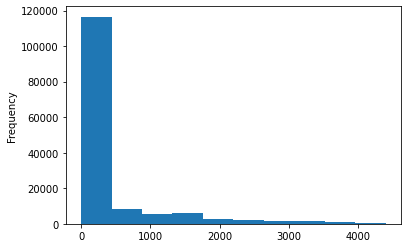

In [ ]:
team_distances['geodesic distance (km)'].plot.hist()

In [ ]:
team_distances['date_diff'] = team_distances['date_diff'].dt.days

In [ ]:
features = pd.merge(
    features,
    team_distances.loc[team_distances['home'] == 0, ['game_id', 'team_id', 'date_diff', 'geodesic distance (km)']],
    how='left',
    left_on=['game_id', 'visitor_id'],
    right_on=['game_id', 'team_id']
).drop(columns=['team_id']).rename(columns={'date_diff': 'visitor_travel_days', 'geodesic distance (km)': 'visitor_travel_distance'})

In [ ]:
features

,game_id,date,season,visitor_id,home_id,visitor_L,home_L,date_index,RD,W,interleague,home_RD_10,home_RD_20,home_RD_30,home_RD_50,home_RD_100,home_win_pct_10,home_win_pct_20,home_win_pct_30,home_win_pct_50,home_win_pct_100,home_rest_1,home_rest_2,home_rest_3,home_rest_4,home_rest_5,home_rest_6,home_rest_7,home_rest_8,home_rest_9,home_rest_10,home_rest_11,home_rest_12,home_rest_13,home_rest_14,home_off_avg_5,home_off_obp_5,home_off_slg_5,home_def_avg_5,home_def_whip_5,home_def_era_5,home_off_avg_10,home_off_obp_10,home_off_slg_10,home_def_avg_10,home_def_whip_10,home_def_era_10,home_off_avg_20,home_off_obp_20,home_off_slg_20,home_def_avg_20,home_def_whip_20,home_def_era_20,home_off_avg_30,home_off_obp_30,home_off_slg_30,home_def_avg_30,home_def_whip_30,home_def_era_30,home_off_avg_50,home_off_obp_50,home_off_slg_50,home_def_avg_50,home_def_whip_50,home_def_era_50,home_off_avg_100,home_off_obp_100,home_off_slg_100,home_def_avg_100,home_def_whip_100,home_def_era_100,visitor_RD_10,visitor_RD_20,visitor_RD_30,visitor_RD_50,visitor_RD_100,visitor_win_pct_10,visitor_win_pct_20,visitor_win_pct_30,visitor_win_pct_50,visitor_win_pct_100,visitor_rest_1,visitor_rest_2,visitor_rest_3,visitor_rest_4,visitor_rest_5,visitor_rest_6,visitor_rest_7,visitor_rest_8,visitor_rest_9,visitor_rest_10,visitor_rest_11,visitor_rest_12,visitor_rest_13,visitor_rest_14,visitor_off_avg_5,visitor_off_obp_5,visitor_off_slg_5,visitor_def_avg_5,visitor_def_whip_5,visitor_def_era_5,visitor_off_avg_10,visitor_off_obp_10,visitor_off_slg_10,visitor_def_avg_10,visitor_def_whip_10,visitor_def_era_10,visitor_off_avg_20,visitor_off_obp_20,visitor_off_slg_20,visitor_def_avg_20,visitor_def_whip_20,visitor_def_era_20,visitor_off_avg_30,visitor_off_obp_30,visitor_off_slg_30,visitor_def_avg_30,visitor_def_whip_30,visitor_def_era_30,visitor_off_avg_50,visitor_off_obp_50,visitor_off_slg_50,visitor_def_avg_50,visitor_def_whip_50,visitor_def_era_50,visitor_off_avg_100,visitor_off_obp_100,visitor_off_slg_100,visitor_def_avg_100,visitor_def_whip_100,visitor_def_era_100,visitor_travel_days,visitor_travel_distance
0,0,1990-04-09,1990,5,2,AL,AL,1.0,3,1,0,-2.3,0.20,0.000000,-0.04,-0.36,0.60,0.525,0.550000,0.52,0.555,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.322034,0.396040,0.446328,0.257310,1.140351,3.157895,0.253049,0.338667,0.344512,0.284091,1.159091,3.988636,0.272727,0.360208,0.385991,0.243004,1.011782,2.902798,0.265672,0.346526,0.378109,0.249008,1.056548,3.026786,0.268524,0.346982,0.384707,0.258886,1.059242,3.103081,0.268532,0.342600,0.387615,0.265841,1.071618,3.055703,0.0,-0.90,-1.100000,-0.40,-0.14,0.40,0.450,0.450000,0.48,0.490,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.263158,0.345178,0.350877,0.301775,1.313609,3.514793,0.281899,0.358442,0.385757,0.292035,1.247788,3.185841,0.272069,0.344031,0.397974,0.297376,1.298834,3.896501,0.270192,0.330427,0.425962,0.283317,1.243830,4.051333,0.265889,0.337312,0.418659,0.271598,1.180473,3.642604,0.258667,0.336914,0.410667,0.256410,1.136852,3.485689,NaN,0.0
1,1,1990-04-09,1990,11,0,AL,AL,1.0,-3,0,0,-0.7,-0.45,-0.933333,-0.42,-0.50,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.315320,0.385108,0.265951,1.091937,3.006961,-2.1,-1.05,-0.500000,-0.40,-0.08,0.40,0.500,0.466667,0.52,0.500,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.209877,0.250000,0.339506,0.308989,1.365169,4.095506,0.224615,0.265896,0.356923,0.274052,1.250729,3.463557,0.241481,0.296599,0.371852,0.250000,1.116071,3.174107,0.256158,0.317204,0.386207,0.246792,1.122409,3

In [ ]:
features = pd.merge(
    features,
    team_distances.loc[team_distances['home'] == 1, ['game_id', 'team_id', 'date_diff', 'geodesic distance (km)']],
    how='left',
    left_on=['game_id', 'home_id'],
    right_on=['game_id', 'team_id']
).drop(columns=['park_ID', 'team_id']).rename(columns={'date_diff': 'home_travel_days', 'geodesic distance (km)': 'home_travel_distance'})

In [ ]:
features

,game_id,date,season,visitor_id,home_id,visitor_L,home_L,date_index,RD,W,interleague,home_RD_10,home_RD_20,home_RD_30,home_RD_50,home_RD_100,home_win_pct_10,home_win_pct_20,home_win_pct_30,home_win_pct_50,home_win_pct_100,home_rest_1,home_rest_2,home_rest_3,home_rest_4,home_rest_5,home_rest_6,home_rest_7,home_rest_8,home_rest_9,home_rest_10,home_rest_11,home_rest_12,home_rest_13,home_rest_14,home_off_avg_5,home_off_obp_5,home_off_slg_5,home_def_avg_5,home_def_whip_5,home_def_era_5,home_off_avg_10,home_off_obp_10,home_off_slg_10,home_def_avg_10,home_def_whip_10,home_def_era_10,home_off_avg_20,home_off_obp_20,home_off_slg_20,home_def_avg_20,home_def_whip_20,home_def_era_20,home_off_avg_30,home_off_obp_30,home_off_slg_30,home_def_avg_30,home_def_whip_30,home_def_era_30,home_off_avg_50,home_off_obp_50,home_off_slg_50,home_def_avg_50,home_def_whip_50,home_def_era_50,home_off_avg_100,home_off_obp_100,home_off_slg_100,home_def_avg_100,home_def_whip_100,home_def_era_100,visitor_RD_10,visitor_RD_20,visitor_RD_30,visitor_RD_50,visitor_RD_100,visitor_win_pct_10,visitor_win_pct_20,visitor_win_pct_30,visitor_win_pct_50,visitor_win_pct_100,visitor_rest_1,visitor_rest_2,visitor_rest_3,visitor_rest_4,visitor_rest_5,visitor_rest_6,visitor_rest_7,visitor_rest_8,visitor_rest_9,visitor_rest_10,visitor_rest_11,visitor_rest_12,visitor_rest_13,visitor_rest_14,visitor_off_avg_5,visitor_off_obp_5,visitor_off_slg_5,visitor_def_avg_5,visitor_def_whip_5,visitor_def_era_5,visitor_off_avg_10,visitor_off_obp_10,visitor_off_slg_10,visitor_def_avg_10,visitor_def_whip_10,visitor_def_era_10,visitor_off_avg_20,visitor_off_obp_20,visitor_off_slg_20,visitor_def_avg_20,visitor_def_whip_20,visitor_def_era_20,visitor_off_avg_30,visitor_off_obp_30,visitor_off_slg_30,visitor_def_avg_30,visitor_def_whip_30,visitor_def_era_30,visitor_off_avg_50,visitor_off_obp_50,visitor_off_slg_50,visitor_def_avg_50,visitor_def_whip_50,visitor_def_era_50,visitor_off_avg_100,visitor_off_obp_100,visitor_off_slg_100,visitor_def_avg_100,visitor_def_whip_100,visitor_def_era_100,visitor_travel_days,visitor_travel_distance,home_travel_days,home_travel_distance
0,0,1990-04-09,1990,5,2,AL,AL,1.0,3,1,0,-2.3,0.20,0.000000,-0.04,-0.36,0.60,0.525,0.550000,0.52,0.555,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.322034,0.396040,0.446328,0.257310,1.140351,3.157895,0.253049,0.338667,0.344512,0.284091,1.159091,3.988636,0.272727,0.360208,0.385991,0.243004,1.011782,2.902798,0.265672,0.346526,0.378109,0.249008,1.056548,3.026786,0.268524,0.346982,0.384707,0.258886,1.059242,3.103081,0.268532,0.342600,0.387615,0.265841,1.071618,3.055703,0.0,-0.90,-1.100000,-0.40,-0.14,0.40,0.450,0.450000,0.48,0.490,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.263158,0.345178,0.350877,0.301775,1.313609,3.514793,0.281899,0.358442,0.385757,0.292035,1.247788,3.185841,0.272069,0.344031,0.397974,0.297376,1.298834,3.896501,0.270192,0.330427,0.425962,0.283317,1.243830,4.051333,0.265889,0.337312,0.418659,0.271598,1.180473,3.642604,0.258667,0.336914,0.410667,0.256410,1.136852,3.485689,NaN,0.0,NaN,0.0
1,1,1990-04-09,1990,11,0,AL,AL,1.0,-3,0,0,-0.7,-0.45,-0.933333,-0.42,-0.50,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.315320,0.385108,0.265951,1.091937,3.006961,-2.1,-1.05,-0.500000,-0.40,-0.08,0.40,0.500,0.466667,0.52,0.500,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.209877,0.250000,0.339506,0.308989,1.365169,4.095506,0.224615,0.265896,0.356923,0.274052,1.250729,3.463557,0.241481,0.296599,0.371852,0.250000,1.116071,3.174107,

In [ ]:
features = features.rename(columns={'visitor_travel_days': 'visitor_days_since_previous_game',
                                    'home_travel_days': 'home_days_since_previous_game'})

In [ ]:
features

,game_id,date,season,visitor_id,home_id,visitor_L,home_L,date_index,RD,W,interleague,home_RD_10,home_RD_20,home_RD_30,home_RD_50,home_RD_100,home_win_pct_10,home_win_pct_20,home_win_pct_30,home_win_pct_50,home_win_pct_100,home_rest_1,home_rest_2,home_rest_3,home_rest_4,home_rest_5,home_rest_6,home_rest_7,home_rest_8,home_rest_9,home_rest_10,home_rest_11,home_rest_12,home_rest_13,home_rest_14,home_off_avg_5,home_off_obp_5,home_off_slg_5,home_def_avg_5,home_def_whip_5,home_def_era_5,home_off_avg_10,home_off_obp_10,home_off_slg_10,home_def_avg_10,home_def_whip_10,home_def_era_10,home_off_avg_20,home_off_obp_20,home_off_slg_20,home_def_avg_20,home_def_whip_20,home_def_era_20,home_off_avg_30,home_off_obp_30,home_off_slg_30,home_def_avg_30,home_def_whip_30,home_def_era_30,home_off_avg_50,home_off_obp_50,home_off_slg_50,home_def_avg_50,home_def_whip_50,home_def_era_50,home_off_avg_100,home_off_obp_100,home_off_slg_100,home_def_avg_100,home_def_whip_100,home_def_era_100,visitor_RD_10,visitor_RD_20,visitor_RD_30,visitor_RD_50,visitor_RD_100,visitor_win_pct_10,visitor_win_pct_20,visitor_win_pct_30,visitor_win_pct_50,visitor_win_pct_100,visitor_rest_1,visitor_rest_2,visitor_rest_3,visitor_rest_4,visitor_rest_5,visitor_rest_6,visitor_rest_7,visitor_rest_8,visitor_rest_9,visitor_rest_10,visitor_rest_11,visitor_rest_12,visitor_rest_13,visitor_rest_14,visitor_off_avg_5,visitor_off_obp_5,visitor_off_slg_5,visitor_def_avg_5,visitor_def_whip_5,visitor_def_era_5,visitor_off_avg_10,visitor_off_obp_10,visitor_off_slg_10,visitor_def_avg_10,visitor_def_whip_10,visitor_def_era_10,visitor_off_avg_20,visitor_off_obp_20,visitor_off_slg_20,visitor_def_avg_20,visitor_def_whip_20,visitor_def_era_20,visitor_off_avg_30,visitor_off_obp_30,visitor_off_slg_30,visitor_def_avg_30,visitor_def_whip_30,visitor_def_era_30,visitor_off_avg_50,visitor_off_obp_50,visitor_off_slg_50,visitor_def_avg_50,visitor_def_whip_50,visitor_def_era_50,visitor_off_avg_100,visitor_off_obp_100,visitor_off_slg_100,visitor_def_avg_100,visitor_def_whip_100,visitor_def_era_100,visitor_days_since_previous_game,visitor_travel_distance,home_days_since_previous_game,home_travel_distance
0,0,1990-04-09,1990,5,2,AL,AL,1.0,3,1,0,-2.3,0.20,0.000000,-0.04,-0.36,0.60,0.525,0.550000,0.52,0.555,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.322034,0.396040,0.446328,0.257310,1.140351,3.157895,0.253049,0.338667,0.344512,0.284091,1.159091,3.988636,0.272727,0.360208,0.385991,0.243004,1.011782,2.902798,0.265672,0.346526,0.378109,0.249008,1.056548,3.026786,0.268524,0.346982,0.384707,0.258886,1.059242,3.103081,0.268532,0.342600,0.387615,0.265841,1.071618,3.055703,0.0,-0.90,-1.100000,-0.40,-0.14,0.40,0.450,0.450000,0.48,0.490,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.263158,0.345178,0.350877,0.301775,1.313609,3.514793,0.281899,0.358442,0.385757,0.292035,1.247788,3.185841,0.272069,0.344031,0.397974,0.297376,1.298834,3.896501,0.270192,0.330427,0.425962,0.283317,1.243830,4.051333,0.265889,0.337312,0.418659,0.271598,1.180473,3.642604,0.258667,0.336914,0.410667,0.256410,1.136852,3.485689,NaN,0.0,NaN,0.0
1,1,1990-04-09,1990,11,0,AL,AL,1.0,-3,0,0,-0.7,-0.45,-0.933333,-0.42,-0.50,0.45,0.425,0.516667,0.48,0.505,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.240741,0.309392,0.376543,0.229299,1.031847,1.719745,0.218659,0.281915,0.349854,0.238938,1.132743,2.867257,0.231988,0.299346,0.364553,0.254438,1.122781,2.556213,0.233918,0.300088,0.362573,0.263054,1.155665,2.793103,0.252444,0.314525,0.387579,0.258348,1.096661,2.862917,0.248109,0.315320,0.385108,0.265951,1.091937,3.006961,-2.1,-1.05,-0.500000,-0.40,-0.08,0.40,0.500,0.466667,0.52,0.500,1.0,1.0,1.000000,1.00,1.0,1.000000,1.000000,1.000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.209877,0.250000,0.339506,0.308989,1.365169,4.095506,0.224615,0.265896,0.356923,0.274052,1.250729,3.463557,0.241481,0.296599,0.371852,0

In [ ]:
features.to_parquet('/content/drive/My Drive/mlb/features/features.parquet')

# add starting pitcher id / name

In [ ]:
features = pd.read_parquet('/content/drive/My Drive/mlb/features/features.parquet')

In [ ]:
features = pd.merge(
    features,
    gl[['game_id', 'visitor_sp_id', 'visitor_sp_name', 'home_sp_id', 'home_sp_name']],
    how='left',
    on='game_id'
)

In [ ]:
features.to_parquet('/content/drive/My Drive/mlb/features/features.parquet')